In [24]:
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np 
import os
import pandas as pd
%matplotlib inline
%autosave 300
%load_ext autoreload
%autoreload 2

from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB


plt.rcParams['figure.figsize'] = (16, 8)
# plt.rcParams['font.size'] = 16
# plt.rcParams['text.usetex'] = False
# plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
# plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
# plt.rcParams['legend.fontsize'] = 16
# plt.rcParams["figure.facecolor"] = 'white'

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_train = pd.read_csv('/Users/tjiang/Desktop/Personal/Stats202/my_repo/Final_Project/data/training.csv', delimiter=',')
df_test = pd.read_csv('/Users/tjiang/Desktop/Personal/Stats202/my_repo/Final_Project/data/test.csv', delimiter=',')

In [6]:
df_train.head()

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1


In [7]:
df_test.head()

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8
0,0,0,4,0,0.13,0.33,0,1,0,0,0.19,0.47
1,0,1,4,0,0.12,0.40,247,477,4,0,0.22,0.59
2,0,2,4,0,0.15,0.41,303,313,44,0,0.20,0.81
3,0,3,4,0,0.06,0.35,1035,415,130,0,0.35,0.77
4,0,51,4,0,0.18,0.33,2,0,0,0,0.21,0.63


In [19]:
Ntrain,Ptrain = map(float, train_predictors.shape)

## Begin by visual inspection of data

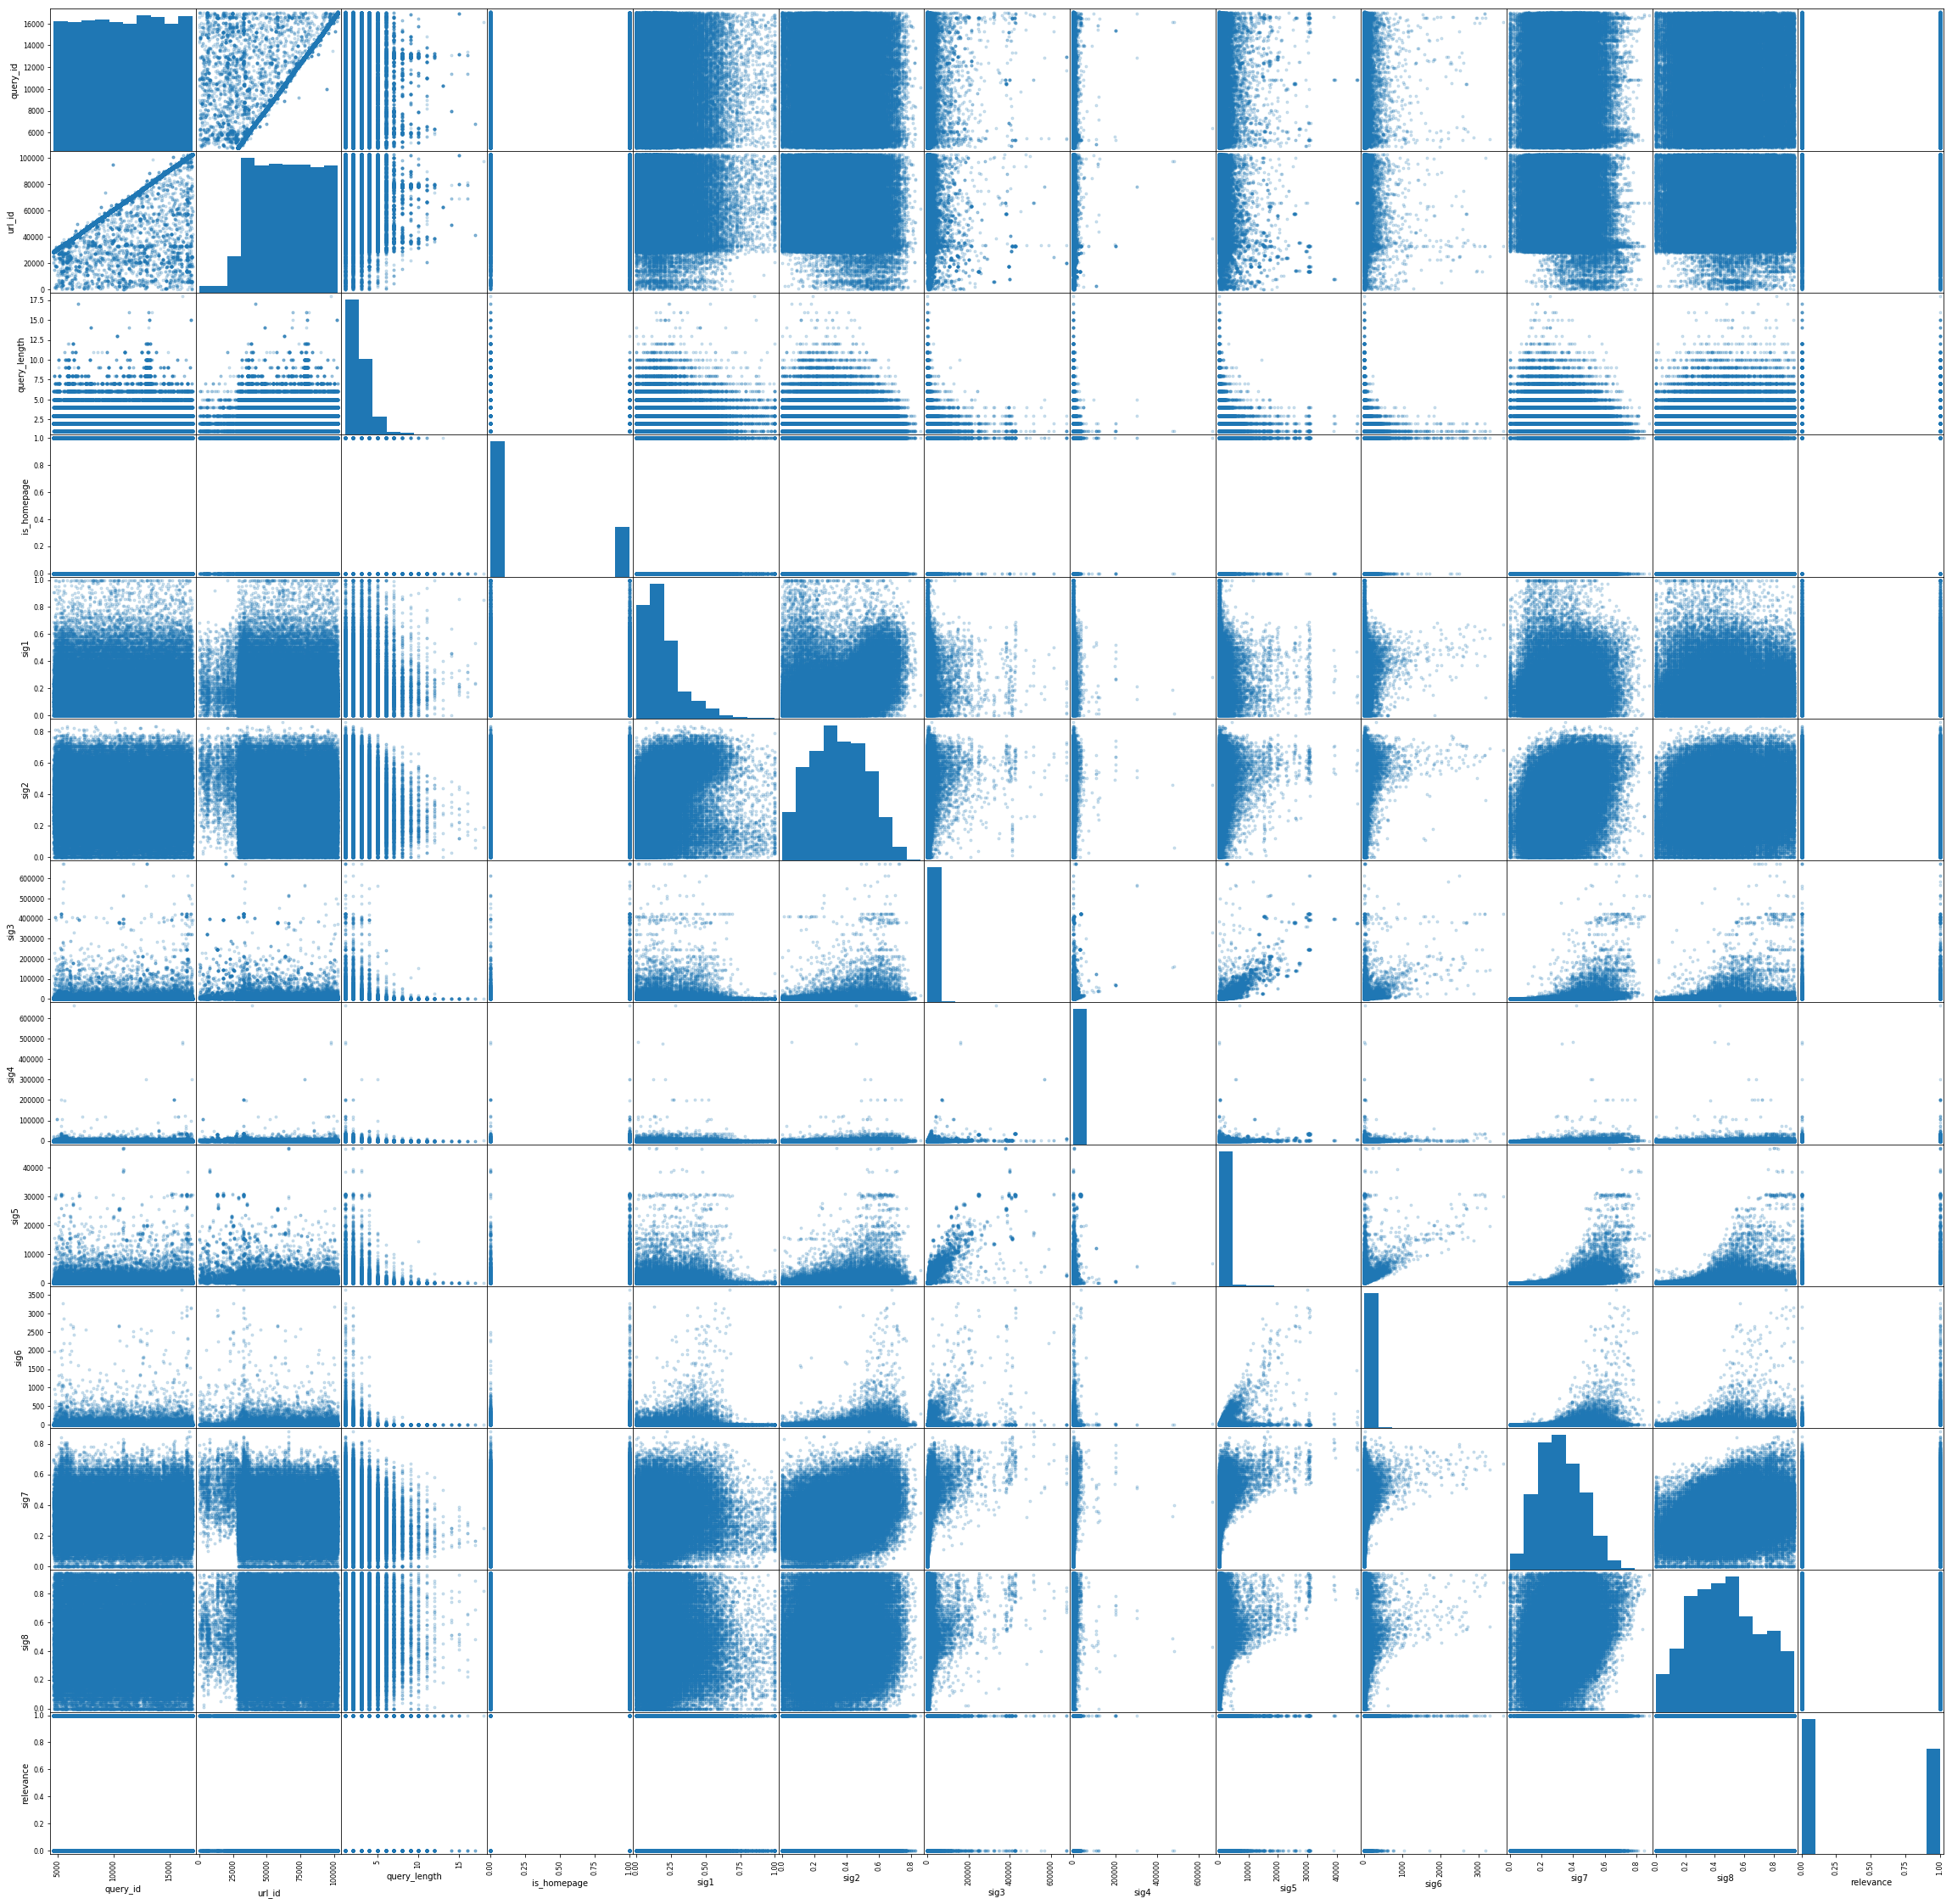

In [10]:
#Redraw to split predictor color
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df_train, alpha=0.2, figsize=(40, 40), diagonal='hist')
pass

## Naïve Bayes

In [9]:
train_predictors = df_train.iloc[:, xrange(2,12)].as_matrix()
train_response = df_train['relevance'].as_matrix()

In [10]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d"
    % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [11]:
gnb.score(iris.data, iris.target)

0.95999999999999996

In [12]:
print train_predictors.shape
print train_response.shape
print df_test.shape
print iris.data.shape
print iris.target.shape

(80046, 10)
(80046,)
(30001, 12)
(150, 4)
(150,)


In [13]:
gnb = GaussianNB()
y_pred = gnb.fit(train_predictors, train_response).predict(train_predictors)
print("Number of mislabeled points out of a total %d points : %d"
    % (train_predictors.shape[0], sum(y_pred != train_response)))

Number of mislabeled points out of a total 80046 points : 32756


In [14]:
from sklearn.naive_bayes import BernoulliNB
gnb = BernoulliNB()
y_pred = gnb.fit(train_predictors, train_response).predict(train_predictors)
# print("Number of mislabeled points out of a total %d points : %d"
#     % (train_predictors.shape[0], (train_response != y_pred).sum()))
print("Number of mislabeled points out of a total %d points : %d"
    % (train_predictors.shape[0], sum(y_pred != train_response)))

Number of mislabeled points out of a total 80046 points : 30654


**10-Fold Cross Validation**

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(iris.data):
    X_train, X_test = iris.data[train_index], iris.data[test_index]
    y_train, y_test = iris.target[train_index], iris.target[test_index]
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Percent of mislabeled points out of a total %d points : %0.2f"
        % (X_test.shape[0], 100*(y_test != y_pred).sum()/float(X_test.shape[0])))

Percent of mislabeled points out of a total 15 points : 0.00
Percent of mislabeled points out of a total 15 points : 0.00
Percent of mislabeled points out of a total 15 points : 0.00
Percent of mislabeled points out of a total 15 points : 6.67
Percent of mislabeled points out of a total 15 points : 6.67
Percent of mislabeled points out of a total 15 points : 13.33
Percent of mislabeled points out of a total 15 points : 0.00
Percent of mislabeled points out of a total 15 points : 13.33
Percent of mislabeled points out of a total 15 points : 13.33
Percent of mislabeled points out of a total 15 points : 0.00


In [36]:
for train_index, test_index in kf.split(train_predictors):
    X_train, X_test = train_predictors[train_index], train_predictors[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    gnb = BernoulliNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Percent of mislabeled points out of a total %d points : %0.2f"
        % (X_test.shape[0], 100*(y_test != y_pred).sum()/float(X_test.shape[0])))

Percent of mislabeled points out of a total 8005 points : 38.06
Percent of mislabeled points out of a total 8005 points : 37.94
Percent of mislabeled points out of a total 8005 points : 38.35
Percent of mislabeled points out of a total 8005 points : 38.36
Percent of mislabeled points out of a total 8005 points : 39.81
Percent of mislabeled points out of a total 8005 points : 38.15
Percent of mislabeled points out of a total 8004 points : 38.88
Percent of mislabeled points out of a total 8004 points : 37.47
Percent of mislabeled points out of a total 8004 points : 37.87
Percent of mislabeled points out of a total 8004 points : 38.54


## **KNN Classifier**

In [17]:
#example
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 
print(neigh.predict([[1.1]]))
print(neigh.predict_proba([[0.9]]))

[0]
[[ 0.66666667  0.33333333]]


In [51]:
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(train_predictors, train_response) 
y_pred = neigh.predict(train_predictors)
print("Percent of mislabeled points out of a total %d points : %0.2f"
    % (Ntrain, 100*(train_response != y_pred).sum()/Ntrain))

Percent of mislabeled points out of a total 80046 points : 38.62


In [52]:
for train_index, test_index in kf.split(train_predictors):
    neigh = KNeighborsClassifier(n_neighbors=50)
    neigh.fit(train_predictors, train_response) 
    y_pred = neigh.predict(train_predictors)
    print("Percent of mislabeled points out of a total %d points : %0.2f"
        % (Ntrain, 100*(train_response != y_pred).sum()/Ntrain))

Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62
Percent of mislabeled points out of a total 80046 points : 38.62


## Support Vector Machine

In [55]:
from sklearn import svm
clf = svm.SVC()
clf.fit(train_predictors, train_response)


KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(train_predictors)